# **Deep Learning Lab: Transfer Learning**

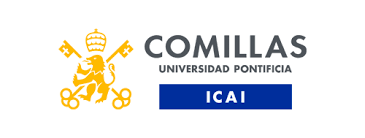

***

In [1]:
import tensorflow as tf

# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Check TPU availability
tpu_available = False
devices = tf.config.list_logical_devices()
for device in devices:
    if device.device_type == 'TPU':
        tpu_available = True
        break

print("TPU Available:", tpu_available)

GPU Available: []
TPU Available: False


## Import packages

In [5]:
from importlib import reload  # Allows reloading user libraries
import sys
#sys.path.append('/content/drive/My Drive/dataset')
import cnn
from cnn import CNN
import torchvision
from cnn import load_data
from cnn import load_model_weights
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import json

## Model and data loading

In [3]:
# Pytorch has many pre-trained models that can be used for transfer learning
classification_models = torchvision.models.list_models(module=torchvision.models)
print(classification_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0

In [6]:
# Load data and model
train_dir = 'dataset/training'
valid_dir = 'dataset/validation'




train_loader, valid_loader, num_classes = load_data(train_dir,
                                                    valid_dir,
                                                    batch_size=128,
                                                    img_size=224) # ResNet50 requires 224x224 images

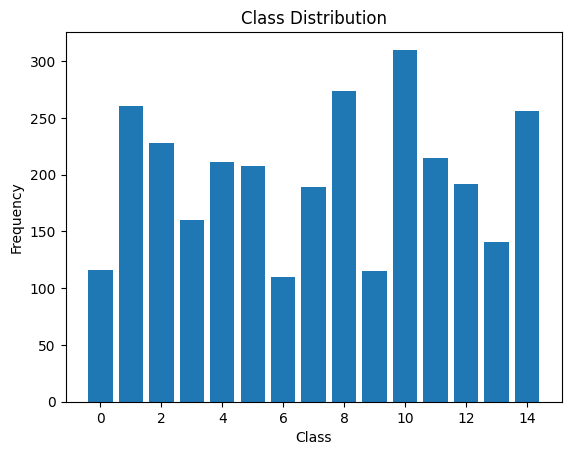

In [ ]:
## CUIDADO, TARDA 14 MINUTOS
# veo la distribución de las clases
class_distribution = np.zeros(num_classes)
for _, labels in train_loader:
    for label in labels:
        class_distribution[label] += 1

plt.bar(range(num_classes), class_distribution)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

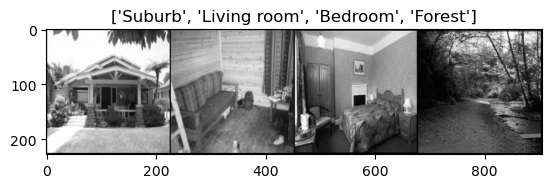

In [7]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(valid_loader.dataset[i][1])
out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])

Comprobacion de que se está usando GPU

## Train

In [8]:
## USO DE GPU EN MAC
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando GPU MPS")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando GPU MPS


In [12]:
# Vamos a analizar la arquitectura de la red renset 50

bm = torchvision.models.resnet50(weights=None)
print(list(bm.children()))

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [11]:
# Si miramos más a fondo
for name, layer in bm.named_modules():
    print(f"{name:40s} → {layer}")

                                         → ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv

In [13]:
model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes, unfreezed_layers=3)
model = model.to(device)

In [14]:

# Verificamos que están descongeladas las capas layer4 (layer4.0, layer4.1, layer4.2) y la nueva cabeza fc
for name, p in model.named_parameters():
    print(f"{name:60s} -> requires_grad={p.requires_grad}")

base_model.conv1.weight                                      -> requires_grad=False
base_model.bn1.weight                                        -> requires_grad=False
base_model.bn1.bias                                          -> requires_grad=False
base_model.layer1.0.conv1.weight                             -> requires_grad=False
base_model.layer1.0.bn1.weight                               -> requires_grad=False
base_model.layer1.0.bn1.bias                                 -> requires_grad=False
base_model.layer1.0.conv2.weight                             -> requires_grad=False
base_model.layer1.0.bn2.weight                               -> requires_grad=False
base_model.layer1.0.bn2.bias                                 -> requires_grad=False
base_model.layer1.0.conv3.weight                             -> requires_grad=False
base_model.layer1.0.bn3.weight                               -> requires_grad=False
base_model.layer1.0.bn3.bias                                 -> requires_gra

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', patience=3, factor=0.1) # Reduce learning rate on plateau, i.e., when the validation loss stops decreasing
criterion = nn.CrossEntropyLoss()
history = model.train_model(train_loader, valid_loader, optimizer, criterion, epochs=30, scheduler=scheduler, patience=6)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/adriandelpozo/.netrc
wandb: Currently logged in as: adriangustavodelpozo (guillaume_-universidad-pontificia-comillas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30 - Train Loss: 2.6589, Train Accuracy: 0.2509
Epoch 1/30 - Validation Loss: 2.5643, Validation Accuracy: 0.3433
Epoch 2/30 - Train Loss: 2.3807, Train Accuracy: 0.5253
Epoch 2/30 - Validation Loss: 2.2697, Validation Accuracy: 0.5853
Epoch 3/30 - Train Loss: 2.1708, Train Accuracy: 0.6737
Epoch 3/30 - Validation Loss: 2.1554, Validation Accuracy: 0.6787
Epoch 4/30 - Train Loss: 2.1191, Train Accuracy: 0.7209
Epoch 4/30 - Validation Loss: 2.0589, Validation Accuracy: 0.7947
Epoch 5/30 - Train Loss: 2.0720, Train Accuracy: 0.7672
Epoch 5/30 - Validation Loss: 1.9927, Validation Accuracy: 0.8560
Epoch 6/30 - Train Loss: 2.0385, Train Accuracy: 0.7920
Epoch 6/30 - Validation Loss: 1.9572, Validation Accuracy: 0.8667
Epoch 7/30 - Train Loss: 2.0114, Train Accuracy: 0.8198
Epoch 7/30 - Validation Loss: 1.9516, Validation Accuracy: 0.8673
Epoch 8/30 - Train Loss: 1.9995, Train Accuracy: 0.8281
Epoch 8/30 - Validation Loss: 1.9380, Validation Accuracy: 0.8813
Epoch 9/30 - Train Loss:

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 18/30 - Validation Loss: 1.8915, Validation Accuracy: 0.9287
Early stopping triggered.


learning_rate,██████████████▁▁▁▁
train_accuracy,▁▄▆▆▇▇▇▇▇█████████
train_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▆▇▇▇▇██████████
validation_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
learning_rate,1e-05
train_accuracy,0.88308
train_loss,1.93858
validation_accuracy,0.92867
validation_loss,1.89149


In [11]:
model.save_model('resnet50_3_unfreeze_layer')

## Predict

#### Load model

In [15]:
# Load model
model_weights = load_model_weights('resnet50_3_unfreeze_layer')
my_trained_model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes)
my_trained_model.load_state_dict(model_weights)

<All keys matched successfully>

## Results

In [16]:
predicted_labels = my_trained_model.predict(valid_loader)

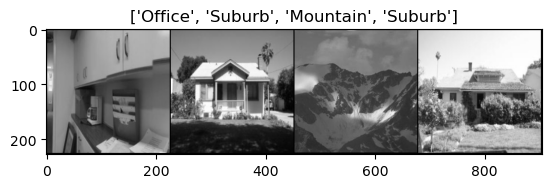

In [17]:
# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(predicted_labels[i])

out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])


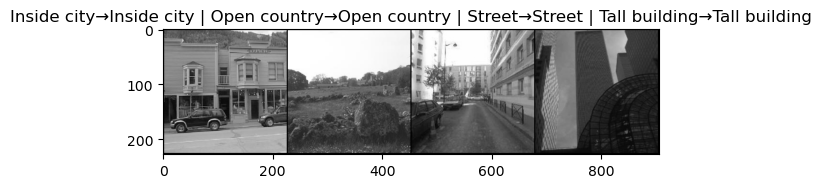

In [18]:
# Selección de índices aleatorios
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)

# Preparamos las entradas, las predicciones y las verdaderas
inputs, preds, trues = [], [], []
for i in random_indices:
    img, true = valid_loader.dataset[i]
    inputs.append(img)
    preds.append(predicted_labels[i])
    trues.append(true)

# Creamos el grid
out = torchvision.utils.make_grid(inputs)

# Generamos un título global que liste True vs Pred para cada subimagen
classnames = train_loader.dataset.classes
labels = [f"{classnames[t]}→{classnames[p]}" for t, p in zip(trues, preds)]
title = " | ".join(labels)

# Mostramos
imshow(out, title=title)

In [20]:
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision
from torchvision.datasets import ImageFolder
from cnn import CNN

# 1) Transform para inferencia (gris → 3 canales)
infer_transform = T.Compose([
    T.Grayscale(num_output_channels=3),
    T.Resize((224, 224)),
    T.ToTensor(),
])

# 2) Carga automática de las clases desde tus datos de validación
dataset = ImageFolder(root='dataset/validation')  # pon aquí la ruta a tu carpeta de validation
class_names = dataset.classes

# 3) Dispositivo (MPS en Mac o CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# 4) Instancia tu modelo (igual que en entrenamiento)
model = CNN(torchvision.models.resnet50(weights=None),
            num_classes=len(class_names),
            unfreezed_layers=3)

# 5) Carga los pesos ya entrenados
model.load_state_dict(torch.load(
    'models/resnet50_3_unfreeze_layer.pt',
    map_location=device
))
model.to(device).eval()

# 6) Función mínima para predecir una imagen suelta
def predict_one(path):
    img = Image.open(path).convert('RGB')
    x   = infer_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_idx = model(x).argmax(1).item()
    return class_names[pred_idx]

# 7) Ejemplo de uso
print(predict_one('test/Coast.jpg'))

Coast
